### Image segmentation using spectral clustering

In [1]:
import time
import random
import copy
import numpy as np
import scipy as sp
import scipy.cluster.vq as vq
from numpy import linalg as la
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering as sklearn_spectral_clustering
from operator import itemgetter
from scipy import spatial

In [13]:
#Path to image file
img_file = './data/tiger.png'

In [14]:
def build_similarity_graph_from_img( img_file ):
    
    # Open Image
    img = Image.open(img_file)
    # Convert image to grayscale
    img = img.convert('L')
    
    # Plot grayscale image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Normalise image intensities to [0,1] values
    img = np.asarray(img).astype(float)/255.0
    print('Image shape is'  + str(img.shape))


    # Convert image into graph with the value of the gradient on the edges.
    # Gradient in this function is defined as the intensity difference relative
    # to 4 adjacent pixels for any given pixel (above, below, left and right pixels)
    graph = image.img_to_graph(img)

    # Take a decreasing function of the gradient: an exponential
    # The smaller beta is, the more independent the segmentation is of the
    # actual image. For beta=1, the segmentation is close to a voronoi
    beta = 5
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps
    
    return (graph,img)

In [15]:
# Function to find reciprocal of Degree matrix (D^-1)
def diag_neg( D ):
    diag_elems = np.nan_to_num( np.diagonal( D ) )
    return np.diag( np.nan_to_num( np.reciprocal( diag_elems ) ) )


In [16]:
# Function to find reciprocal of root of Degree matrix (D^-0.5)
def diag_neg_root( D ):
    D_root = np.sqrt( D )
    D_neg_root = diag_neg( D_root )
    return D_neg_root

In [17]:
# Function to find the kernel weights between 2 vectors x and u
def gaussian_kernel( x, u ):
    h = 1
    norm = np.linalg.norm(x - u)
    return np.exp(-(norm**2)/(2*(h**2)))

In [18]:
# Link to Landmark Based Spectral Clustering Paper : https://www.cs.cmu.edu/~xinleic/papers/aaai11.pdf
def landmark_based_SC( X, k ):
    
    p = int( np.sqrt( X.shape[0] ) )
    
    # Matrix X can be viewed as 'n' data points, each of dimension 'm'
    m,n = X.shape

    # If in Sparse COO matrix convert to array
    X = X.toarray()
            
    # Choose p points/indices without repetition from [0,n)
    U_idx = np.random.choice( range(n), p, replace=False )

    # Fill those p randomly chosen points from matrix X into U
    U = np.zeros((m,p))
    for i in range(p):
        U[:,i] = X[:,U_idx[i]]
    print(U)
            
    # Number of nearest landmark points from the 'p' points of U that we need to
    # consider for calculating U_r
    r = int(p/2)
    xi = np.zeros((m,1))
    Z = np.zeros((p,n))
    
    time_for_nw_regression = 0
    t_start = time.time()
    for i in range(n):
                
        # xi indicates every datapoint of matrix
        xi[:,0] = X[:,i]
                
        # U_r_idx populates xi's 'r' nearest vector's(datapoints) indices in U
        
        '''
        U_dist_from_xi = np.zeros((p,2))
        for j in range(p):
            U_dist_from_xi[j][0] = int(j)
            U_dist_from_xi[j][1] = np.linalg.norm(xi - U[:,j])
        
        sorted_U_dist_from_xi = np.array( sorted( U_dist_from_xi,key=itemgetter( 1 ) ) )
        U_r_idx = (sorted_U_dist_from_xi[:r][:,0]).flatten().astype(int)
        ''' 
        
        tree = spatial.KDTree(np.transpose(U))
        U_r_idx = (tree.query(np.transpose(xi),k=r)[1]).flatten()
        
        # Z_list stores gaussian kernel weights between xi and 'r' nearest
        # neighbours to xi in the matrix U
        # Nadraya Watson Kernel Regression
        Z_list = np.zeros(U_r_idx.size)
        ctr=0
        for j in U_r_idx:
            Z_list[ctr] = gaussian_kernel( xi, U[:,j] )
            ctr+=1
        
        # Normalize and fill weights in Z matrix
        ctr=0
        if( sum( Z_list ) ):
            for j in U_r_idx:
                Z[j,i] = Z_list[ctr]/sum(Z_list)
                ctr+=1

    t_end = time.time()
    time_for_nw_regression += (t_end-t_start)
    
    assert( np.isnan(Z).any() == False )
    
    D = np.diag( np.ravel( np.sum( Z, axis=1 ) ) )
    D_neg_root = diag_neg_root( D )
    
    # Compute Z_hat = D^-0.5 * Z
    Z_hat = np.dot( D_neg_root, Z )

    # SVD of Z_hat gives B_tran
    A, S, B_tran = np.linalg.svd( Z_hat, full_matrices=False )
    B = np.transpose( B_tran )

    # What B has right now would be the eigenvectors of (Z_hat * Z_hat.T)
    means, labels = vq.kmeans2(B[:,0:k],k)
    
    print('LandMark based time spent calculating nearest neighbour - ' + str(time_for_nw_regression) )
    return labels

In [19]:
# 2 types of Laplacian graphs
def Laplacian_graph( A, D, clustering_type='unnormalized' ):
    
    I = np.identity( A.shape[0] )
    if( clustering_type == 'unnormalized' ):
        L = D - A
        
    elif(  clustering_type == 'random_walk_normalized'  ):
        L = I - ( A / np.diagonal( D )[:,None] )
        
    return L

In [20]:
# Link to tutorial on Spectral Clustering : https://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf
def spectral_clustering( graph, num_clusters, clustering_type ):
    
    k = num_clusters
    A = graph
    
    if( clustering_type == 'LANDMARK_BASED' ):
        return landmark_based_SC( A, k )
    
    elif( clustering_type == 'sklearn_spectral_clustering' ):
        return sklearn_spectral_clustering(graph, n_clusters=num_clusters,
                                           assign_labels='kmeans', random_state=1)
    
    D = np.diag( np.ravel( np.sum( A, axis=1 ) ) )

    L = Laplacian_graph( A, D, clustering_type )

    # V has matrix of all eigenvectors arranged and l has sorted eigenvalues
    l, V = la.eigh( L )

    # First K columns of V need to be clustered
    V_k_dim = V[:,0:k]
    
    U = V_k_dim

    
    if( k==2 ):
        # In this case clustering on the Fiedler vectorwhich gives very close approximation
        f = U[:,1]
        labels = np.ravel( np.sign( f ) )
        k=2
    else:
        # Run K-Means on eigenvector matrix ( Other than 0th column )
        # means --> K-means cluster centres
        # labels --> Cluster labels detected
        # Note that some times K-Means might not converge and you might have 1 cluster lesser than 'K'
        means, labels = vq.kmeans2( U[:,1:k], k )
        print(U[:,1:k].shape, labels.shape)
        
    return labels

In [21]:
def kMeans( graph, num_clusters ):
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(graph.toarray())
    #means, labels = vq.kmeans2( graph.toarray(), num_clusters )
    return kmeans.labels_

In [22]:
def plot_segmented_image( img, labels, num_clusters, run_time, title ):
    plt.figure( figsize=( 5, 5 ) )
    plt.imshow(img, cmap=plt.cm.gray)
    for l in range( num_clusters ):
        try:
            plt.contour( labels == l, contours=1, colors= [plt.cm.spectral( l / float( num_clusters ) )] )
        except ValueError:  #raised if `y` is empty.
            pass

    plt.xticks(())
    plt.yticks(())
    plt.legend(loc='best')
    if(title):
        plt.title(title + ': %.2fs' %run_time)
    else:
        plt.title('Spectral clustering: %.2fs' %run_time)
    plt.show()


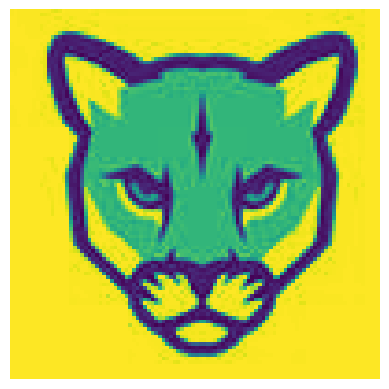

Image shape is(100, 100)
Graph from Image done in : 0.10s
Similarity Graph Shape - (49600,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


KeyboardInterrupt: 

In [23]:
num_clusters = 3

# Open image and build a similarity graph defined by a measure of similarity beteen pixels

t0 = time.time()
similarity_graph,img = build_similarity_graph_from_img( img_file )
assert( similarity_graph.shape[i] == img.shape[i]**2 for i in range( 2 ) )
t1 = time.time()

print( 'Graph from Image done in : %.2fs' %( t1 - t0 ) )

# Spectral clustering on the similarity graph to find a given number of clusters

for clustering_type in [ 'LANDMARK_BASED', 'unnormalized', 'random_walk_normalized', 'sklearn_spectral_clustering']:

    t1 = time.time()
    print( 'Similarity Graph Shape - ' + str( similarity_graph.data.shape ) )
    labels = spectral_clustering( similarity_graph, num_clusters, clustering_type )
    t2 = time.time()

    print( 'Spectral Clustering ( ' + str(clustering_type) + ' ) done in : %.2fs' %( t2 - t1 ) )

    labels = labels.reshape( img.shape )
    plot_segmented_image( img, labels, num_clusters, (t2 - t1), 'Spectral Clustering ( ' + str(clustering_type) + ' )' )

# KMeans clustering on original graph for comparison with Spetal clustering results

t1 = time.time()
labels = kMeans(similarity_graph, num_clusters )
t2 = time.time()

labels = labels.reshape( img.shape )
plot_segmented_image( img, labels, num_clusters, (t2 - t1), 'Kmeans' ) 